# PRODUCT RECOGNITION ON STORE SHELVES

### Manuel Gabrielli - manuel.gabrielli@studio.unibo.it


---


## Step B - Multiple Instance Detection

- Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In addition to what achieved at step A, the system should now be able to detect multiple instance of the
same product.

In [32]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [33]:
def readImages():
    #open and conversion to original colours
    images = {}
    for i in range(num_models):
        img = cv2.imread(models_path+str(model_index[i])+models_estenstion);
        images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    
    #open and conversion to original colours
    scenes = {}
    for i in range(num_scenes):
        scenes[i] = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion);
        scenes[i] = cv2.cvtColor(scenes[i],cv2.COLOR_BGR2RGB);
        
    grey_scenes = {}
    for i in range(num_scenes):
        grey_scenes[i] = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion, 0);
        
    return images, scenes, grey_scenes

In [34]:
def getFeatureMatcher():
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    return flann

In [35]:
def getKeypoints(image):
    # find the keypoints and descriptors with SIFT
    kp_image = sift.detect(image)
    
    # Describing keypoints for image
    kp_image, des_image = sift.compute(image, kp_image)
    
    return kp_image, des_image

In [36]:
def computeBarycenter(kp_query):
    sum_x = 0
    sum_y = 0
    for i in range(len(kp_query)):
        sum_x = sum_x + kp_query[i].pt[0]
        sum_y = sum_y + kp_query[i].pt[1]
    bar = (int(sum_x/len(kp_query)), int(sum_y/len(kp_query)))
    return bar

In [37]:
def computeVectors(kp_models, barycenter):
    vectors = {}
    for i in range(len(kp_models)):
        vectors[i] = (barycenter[0] - kp_models[i].pt[0], barycenter[1] - kp_models[i].pt[1])
    return vectors

In [38]:
def voting(imageShape, dst_points, vectors, ind_model):
    votes = []
    acc = np.zeros(imageShape)
    for j in range(len(dst_points)): 
        #dst_points[j][1] indice del kp_model associato al kp_train
        vec = vectors[dst_points[j][1]]
       
        diff_scale = dst_points[j][0].size/kp_models[ind_model][dst_points[j][1]].size
        
        vec = (diff_scale*vec[0], diff_scale*vec[1])
        
        vote = [sum(tup) for tup in zip(dst_points[j][0].pt, vec)]
        
        #controllo se esce dall'immagine
        if(vote[0]>= 0 and vote[0]<= imageShape[1] and vote[1]>= 0 and vote[1] <= imageShape[0]):
            acc[int(vote[1]), int(vote[0])] += 1
            votes.append([dst_points[j][0], (int(vote[0]), int(vote[1]))])
           
    return acc, votes

In [39]:
def getPossibleBarycenters(accumulator, min_votes):
    barycenters=[]
    row, col = accumulator.shape
    
    for i in range(row):
        for j in range(col):
            #servono min_votes voti per essere considerato un poteziale baricentro
            if(accumulator[i,j]>= min_votes):
                barycenters.append([j,i])
    return barycenters

In [40]:
#function to filter barycentres list according to votes in their neighbourhood
def outliersFilter(filtered_bar, accumulator, RANGE, MIN_COUNT):
    
    res = filtered_bar.copy()
    row, col = accumulator.shape
    removed_bar = []
    count = 0
    
    for k in range(len(res)):
        start_row = filtered_bar[k][1] - RANGE
        start_col = filtered_bar[k][0] - RANGE
        end_row = filtered_bar[k][1] + RANGE
        end_col = filtered_bar[k][0] + RANGE

        #controllo che non escano dai limiti dell'immagine
        if (end_row > row):
            end_row = row
        if (start_row < 0):
            start_row = 0

        if (end_col > col):
            end_col = col
        if (start_col < 0):
            start_col = 0

        for i in range(start_row, end_row):
            for j in range(start_col, end_col):
                if (accumulator[i, j] > 1):
                    count = count + accumulator[i, j]
       
        #se è minore lo aggiungo agli elementi da rimuovere
        if count < MIN_COUNT:
            removed_bar.append(filtered_bar[k])
        count = 0

    for i in removed_bar:
        res.remove(i)
    
    return res

In [41]:
#function to compute euclidian distance
def euclidianDistance(point_1,point_2):
    dist = np.sqrt((point_1[0]-point_2[0])**2+(point_1[1]-point_2[1])**2)
    return dist

In [42]:
#function to filter a barycentres list making mean between closest ones
def distanceFilter(barycentres, distance):
    filtered_bar = []
    len_bar = len(barycentres)
    
    for i in range(len_bar):
        
        if (barycentres[i] != [-1,-1]):
            sum_b = barycentres[i].copy()
            count_b = 1
            next_index=i+1
            
            for j in range(next_index,len_bar):
                #non faccio il confronto con uno già stato analizzato
                if(barycentres[j] != [-1,-1]):
                    
                    dist = euclidianDistance(barycentres[i],barycentres[j])
                    #qui crea un nuovo baricentro facendo la media tra quelli trovati
                    if(dist<distance):
                        sum_b[0] = sum_b[0]+barycentres[j][0]
                        sum_b[1] = sum_b[1]+barycentres[j][1]
                        barycentres[j] = [-1,-1] #lo metto uguale a [-1,-1] così poi non viene più analizzato
                        count_b += 1
                
            #alla fine faccio la media
            sum_b[0] = int(round(sum_b[0] / count_b))
            sum_b[1] = int(round(sum_b[1] / count_b))
            filtered_bar.append(sum_b)
                    
    return filtered_bar

# ora collego i keypoints dell'immagine della scena ai giusti baricentri


In [43]:
def getCorrectKeypoints(bar_found, votes, imageShape, good, RANGE):
    final_good=[]
    
    for vote in votes:
        bar_x, bar_j = (int(vote[1][0]), int(vote[1][1]))
      
        if (0 < bar_x < imageShape[1] and 0 <bar_j < imageShape[0]):
            if((bar_found[0]-RANGE < bar_x < bar_found[0]+RANGE) 
               and (bar_found[1]-RANGE < bar_j < bar_found[1]+RANGE)):
                final_good.append(good.get(vote[0]))
                
    return final_good

In [44]:
def generalizedHoughTransform(grey_scene, models):
    
    #qui è dove si salva l'elenco di tutti i baricentri per ogni modello nella scena
    barycenters_list = {}
    final_good = {}
    threshold = 0.8
    min_votes = 2
    range_outliers = 20
    count_outliers = 2
    distance = 100
    range_final_keypoints = 50
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_models[i],des_scene,k=2)
    
        #get first good matches
        good = {}
        for m,n in matches:
            if m.distance < threshold*n.distance:
                good[kp_scene[m.trainIdx]] =  m
            
            
        #get points matchati nella immagine di train
        #dst_points sono nell'ordine scritto in good
        dst_points = []
        for k,m in good.items():
            dst_points.append((k, m.queryIdx))
            #dst_points.append((k, m.queryIdx))
    
        
        accumulator, votes = voting(grey_scene.shape, dst_points, vectors[i], i)
        
        possible_b = getPossibleBarycenters(accumulator, min_votes)
       
        #First filter to discard outliers
        filtered_bar = outliersFilter(possible_b,accumulator, range_outliers, count_outliers)

        #Second filter to obtain a single barycenter from a group of close barycenters
        barycenters_list[i] = distanceFilter(filtered_bar, distance)

        #Find now the right "good" vectors
        final_good[i] = {}
        for j in range(len(barycenters_list[i])):
            final_good[i][j]= getCorrectKeypoints(barycenters_list[i][j], votes, grey_scene.shape, good, range_final_keypoints)
        
    return barycenters_list, final_good

# ora che ho trovato i keypoints disegno i modelli sull'immagine

In [45]:
# the centroid or geometric center of a plane figure is the arithmetic mean position of all the points in the shape.
#calculated by the sum of the x coord divided by the number and the sum of y coord dividend by the number
def getCentroid(vertices):
    sum_coord = [0,0]
    for i in range(len(vertices)):
        sum_coord = sum_coord + vertices[i][0]
    return (int(sum_coord[0]/len(vertices)), int(sum_coord[1]/len(vertices)))

In [46]:
def printResults(occurences, scene_name): 
    print("Scene "+scene_name+":\n")
    
    for o in occurences.keys():
        print("\nProduct {} - {} instances found:\n".format(o, len(occurences[o])))

        # esempio di dato: [{'height': 438, 'width': 310, 'center': (162, 214)}]

        listOcc = occurences[o]

        for i in range(len(listOcc)):
            center = listOcc[i]["center"]
            height = listOcc[i]["height"]
            width = listOcc[i]["width"]
            print("\tInstance "+str(i+1)+": {position: ("+str(center[0])+","+str(center[1])+"), width: "+str(width)+"px, heigh: "+str(height)+"px}")


In [47]:
def searchTemplates(models, scene, barycenters, final_good, LIMIT_INC):
    
    per_check = []
    #loop over all the possible models
    for i in range(len(models)):

        for j in range(len(barycenters[i])):
            
            if len(final_good[i][j])>=MIN_MATCH_COUNT:
               
               # building the corrspondences arrays of good matches
                src_pts = np.float32([ kp_models[i][m.queryIdx].pt for m in final_good[i][j] ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in final_good[i][j] ]).reshape(-1,1,2)
                # Using RANSAC to estimate a robust homography. 
                # It returns the homography M and a mask for the discarded points
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Mask of discarded point used in visualization
                matchesMask = mask.ravel().tolist()

                # Corners of the query image
                h,w = images[i].shape[0:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                # Projecting the corners into the train image
                dst = cv2.perspectiveTransform(pts,M)

                #FACENDO IL CONTROLLO SUL COLORE DELL'AREA CAPISCONO QUALI SONO LE SCATOLE PRESENTI E QUALI NO

                #controlla che la scatola non sia troppo inclinata, e quindi storpiata
                if ((abs(dst[0,0][0]-dst[1,0][0])<LIMIT_INC) and abs(dst[0,0][1]-dst[3,0][1])<LIMIT_INC 
                    and abs(dst[2,0][0]-dst[3,0][0])<LIMIT_INC and abs(dst[1,0][1]-dst[2,0][1])<LIMIT_INC):
                
                    #if dealing with chocokrave (correct model)
                    if (model_index[i] == 1 or model_index[i]==11):
                        dst= np.int32(dst)+(0,30)

                    #cambio le coordinate per non avere indici negativi o indici che eccedono la dimensione dell'immagine
                    x_min=int((dst[0,0][0]+dst[1,0][0])/2)
                    if(x_min<0):
                        x_min=0
                    if(x_min>=scene.shape[1]): #se esce dalla figura perchè è maggiore della dimensione della scena lo metto a uno 
                        x_min=scene.shape[1]-1 #in meno rispetto alla dimensione della scena
                    y_min=int((dst[0,0][1]+dst[3,0][1])/2)
                    if(y_min<0):
                        y_min=0
                    if(y_min>=scene.shape[0]):
                        y_min=scene.shape[0]-1
                    x_max=int((dst[2,0][0]+dst[3,0][0])/2)
                    if(x_max<0):
                        x_max=0
                    if(x_max>=scene.shape[1]):
                        x_max=scene.shape[1]-1
                    y_max=int((dst[1,0][1]+dst[2,0][1])/2)
                    if(y_max<0):
                        y_max=0
                    if(y_max>=scene.shape[0]):
                        y_max=scene.shape[0]-1

                    #escludo il primo terzo
                    #calcolo max_y(y2)-min_y(y1)/3 e sommo y_1 per traslarlo
                    start_row = int(y_min+(y_max-y_min)/3)
                    
                    #control over the colour of a significant area
                    area = scene[start_row:y_max, x_min:x_max]
                    
                    #se l'area selezionata non è vuota
                    if(area.shape[0] != 0 and area.shape[1]!= 0):
                      
                        average_area_row = np.average(area, axis=0)
                        average_area = np.average(average_area_row, axis=0).astype(int).tolist()

                        color_first=abs(average_colors[i][0]-average_area[0])
                        color_second=abs(average_colors[i][1]-average_area[1])
                        color_third=abs(average_colors[i][2]-average_area[2])

                        #check on colour mean
                        DIFF_COLOUR = 30
                        #la differenza tra il colore primario ottenuto dell'area e quello del modello deve essere entro certi parametri
                        if(color_first < DIFF_COLOUR and color_second < DIFF_COLOUR and color_third < DIFF_COLOUR):
                            
                            width = int(round(dst[2,0][0] - dst[0,0][0]))
                            height = int(round(dst[1,0][1] - dst[0,0][1]))
                            lower_width = int(round(dst[3,0][0] - dst[1,0][0]))
                            lower_height = int(round(dst[2,0][1] - dst[3,0][1]))
                            perimeter=width+lower_width+height+lower_height
                            per_check.append({"index":model_index[i],"perimeter":perimeter, "dst":dst})
                            
            else:
                matchesMask = None

    return per_check

In [48]:
def drawResults(scene, per_check, scene_name):
    
    current_index = -1
    occurences = {}
    
    per = []
    for i in range(len(per_check)):
        per.append(per_check[i]["perimeter"])
    median_p = np.median(per)
    
    for i in range(len(per_check)):
        perimeter = per_check[i]["perimeter"]
        
        #se il perimetro rientra dentro un certo range possibili di valori
        if(range_perimeter[0]*median_p < perimeter < range_perimeter[1]*median_p):
            dst = per_check[i]["dst"]
            model_ind = per_check[i]["index"]

            if(current_index != model_ind):
                current_index = model_ind
                occurences[current_index] = []

            text = model_texts[model_ind]

            # Drawing the bounding box
            scene = cv2.polylines(scene,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=3)[0]
            offset_1=(int(dst[1,0][0]), int(dst[1,0][1])+10)
            offset_2=(int(dst[2,0][0]), int(dst[1,0][1])-text_height-5)
            cv2.rectangle(scene,offset_1, offset_2, (0,255,0), cv2.FILLED)
            width = int(round(dst[2,0][0] - dst[0,0][0]))
            height = int(round(dst[1,0][1] - dst[0,0][1]))
            #centered position of the text wrt the rectangle
            org = (int(dst[1,0][0]+(width/2-text_width/2)), int(dst[1,0][1])) 
            cv2.putText(scene,text,org, font, font_scale,(0,0,0),3,cv2.LINE_AA)

            #get center of the box
            center = getCentroid(dst)

            occurences[current_index].append({"height": height, "width": width, "center": center})

    #stampo i risultati ottenuti
    printResults(occurences, scene_name)
    
    #print scene image
    plt.figure(figsize=(20, 10))
    plt.imshow(scene);
    plt.show();

In [49]:
#PARAMETERS

#MODEL IMAGES
model_index = {
    0: 0,
    1: 1,
    2: 11,
    3: 19,
    4: 24,
    5: 25,
    6: 26
}

model_texts = {
    0: "Nesquik",
    1: "CK Blue",
    11: "CK Orange",
    19: "Country Crisp",
    24: "Fitness",
    25: "Coco Pops",
    26: "Nesquik Duo",
}

models_estenstion = ".jpg"

models_path = "models/"

num_models = len(model_index);

#SCENES IMAGES
scenes_names = ["m1","m2","m3","m4","m5"]

scenes_estenstion = ".png"

scene_path = "scenes/"

num_scenes = len(scenes_names)

#MACRO VARIABLES
font = cv2.FONT_ITALIC
font_scale=1.0

# Checking if we found enough matching
MIN_MATCH_COUNT = 10
range_perimeter = (0.82,1.4)
LIMIT_INC = 50

In [50]:
images, scenes, grey_scenes = readImages()

#get avarage colour of each model image
average_colors = {}

for i in range(num_models):
    #non considero il primo terzo dell'immagine che molte volte contiene il logo della marca
    start_row = int(images[i].shape[0]/3)
    #seleziono la parte dell'imagine da considerare
    selected_image = images[i][start_row: images[i].shape[0], :]
    #faccio la media
    average_color_row = np.average(selected_image, axis=0)
    average_colors[i] = np.average(average_color_row, axis=0).astype(int).tolist()
    
#Initiate SIFT detector
sift = cv2.SIFT_create()
flann = getFeatureMatcher()

kp_models = {}
des_models = {}
barycenters = {}
vectors = {}

for i in range(num_models):
    # Describing keypoints for model images
    kp_models[i], des_models[i] = getKeypoints(images[i])
    barycenters[i] = computeBarycenter(kp_models[i])
    vectors[i] = computeVectors(kp_models[i], barycenters[i])

Scene m1:


Product 24 - 2 instances found:

	Instance 1: {position: (184,214), width: 363px, heigh: 503px}
	Instance 2: {position: (550,220), width: 340px, heigh: 489px}

Product 25 - 1 instances found:

	Instance 1: {position: (1262,237), width: 308px, heigh: 453px}

Product 26 - 2 instances found:

	Instance 1: {position: (921,218), width: 330px, heigh: 491px}
	Instance 2: {position: (921,218), width: 330px, heigh: 491px}


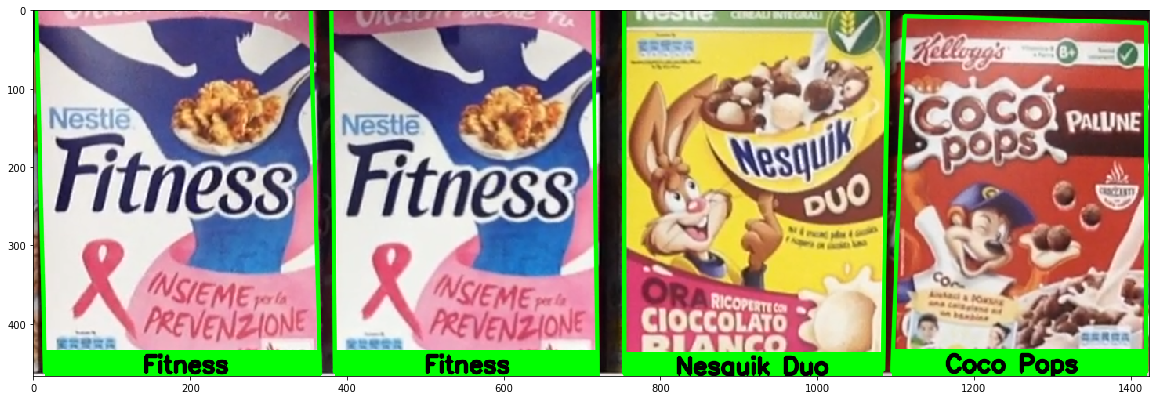

Scene m2:


Product 0 - 1 instances found:

	Instance 1: {position: (178,300), width: 348px, heigh: 453px}

Product 1 - 2 instances found:

	Instance 1: {position: (1180,283), width: 297px, heigh: 415px}
	Instance 2: {position: (844,280), width: 309px, heigh: 424px}

Product 11 - 1 instances found:

	Instance 1: {position: (535,285), width: 368px, heigh: 307px}


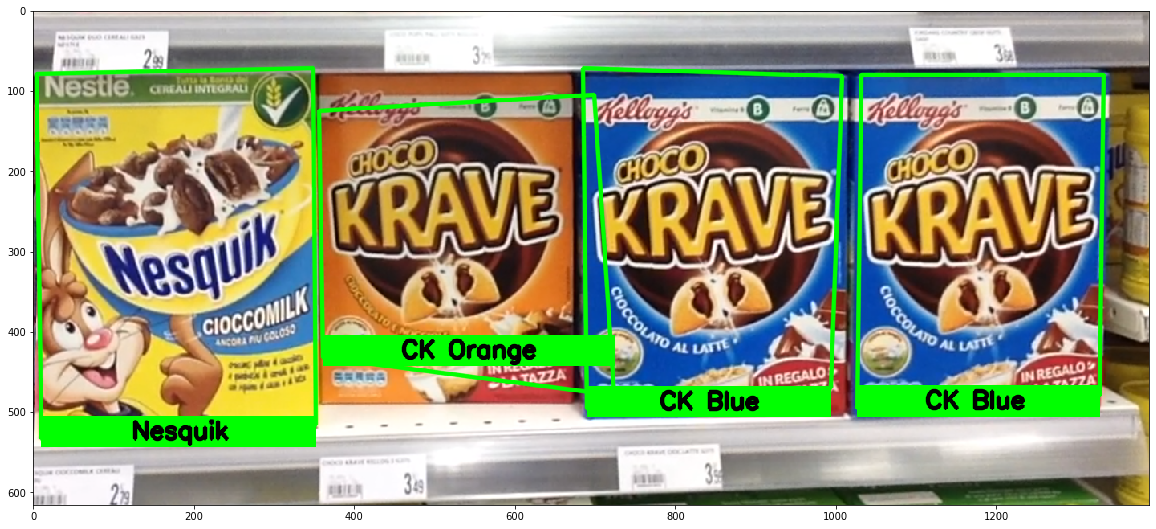

Scene m3:


Product 19 - 1 instances found:

	Instance 1: {position: (1233,189), width: 291px, heigh: 386px}

Product 25 - 2 instances found:

	Instance 1: {position: (890,226), width: 311px, heigh: 442px}
	Instance 2: {position: (558,221), width: 331px, heigh: 456px}

Product 26 - 1 instances found:

	Instance 1: {position: (195,206), width: 364px, heigh: 509px}


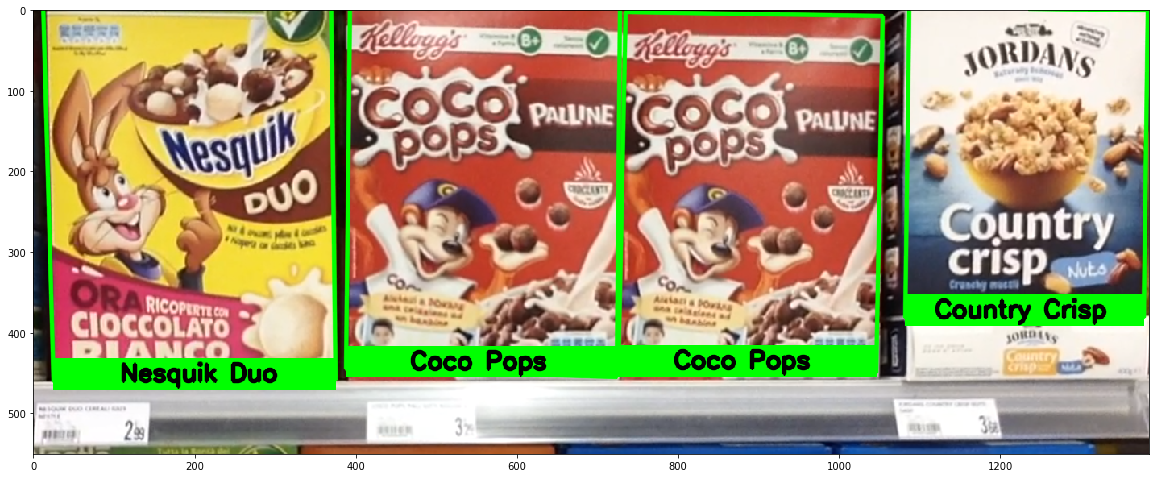

Scene m4:


Product 24 - 2 instances found:

	Instance 1: {position: (161,193), width: 377px, heigh: 504px}
	Instance 2: {position: (540,196), width: 359px, heigh: 501px}

Product 25 - 2 instances found:

	Instance 1: {position: (1588,211), width: 298px, heigh: 435px}
	Instance 2: {position: (1271,210), width: 316px, heigh: 452px}

Product 26 - 1 instances found:

	Instance 1: {position: (921,195), width: 343px, heigh: 498px}


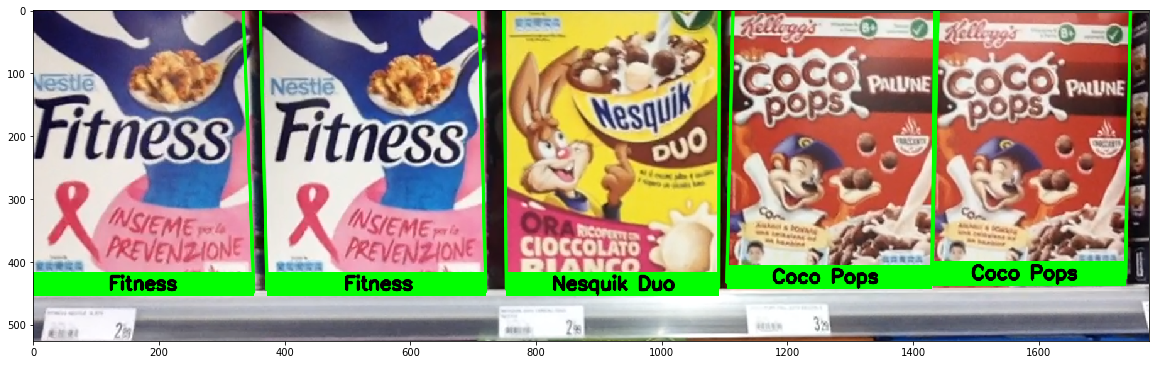

Scene m5:


Product 1 - 2 instances found:

	Instance 1: {position: (500,751), width: 313px, heigh: 413px}
	Instance 2: {position: (834,745), width: 297px, heigh: 411px}

Product 11 - 1 instances found:

	Instance 1: {position: (162,741), width: 310px, heigh: 402px}

Product 19 - 1 instances found:

	Instance 1: {position: (908,190), width: 291px, heigh: 389px}

Product 25 - 2 instances found:

	Instance 1: {position: (234,223), width: 333px, heigh: 455px}
	Instance 2: {position: (566,228), width: 313px, heigh: 445px}


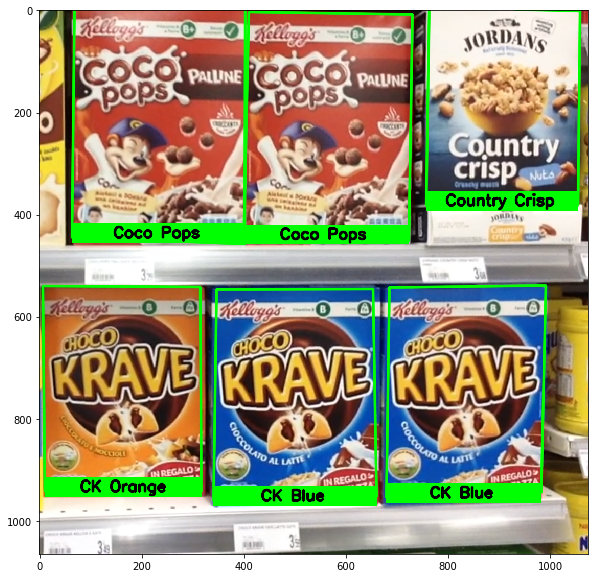

In [51]:
for i in range(num_scenes):
    #creo una copia della scena da modificare
    copy_scene = np.copy(scenes[i])
    kp_scene = sift.detect(grey_scenes[i])
    kp_scene, des_scene = sift.compute(grey_scenes[i], kp_scene)
    barycenters_list, final_good = generalizedHoughTransform(grey_scenes[i], images)
    per_check = searchTemplates(images, copy_scene, barycenters_list, final_good, LIMIT_INC)
    drawResults(copy_scene, per_check, scenes_names[i])

# Correction Step A

Scene e3:


Product 0 - 1 instances found:

	Instance 1: {position: (170,237), width: 327px, heigh: 447px}

Product 1 - 1 instances found:

	Instance 1: {position: (818,220), width: 304px, heigh: 409px}

Product 11 - 1 instances found:

	Instance 1: {position: (474,219), width: 304px, heigh: 394px}


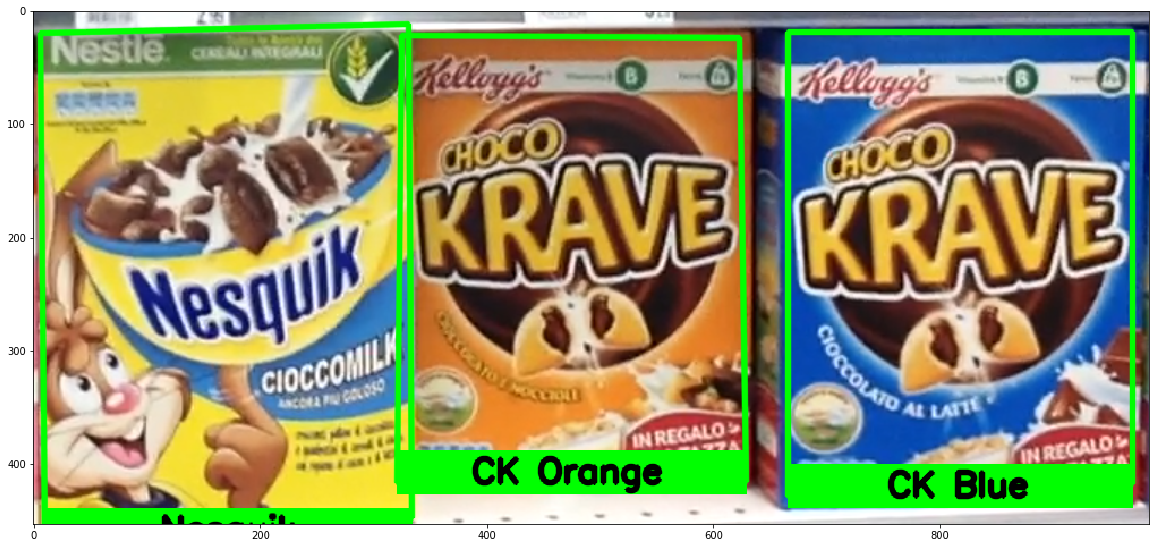

In [52]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 30

scene_name = "e3"


scene =  cv2.imread(scene_path+scene_name+scenes_estenstion);
scene = cv2.cvtColor(scene,cv2.COLOR_BGR2RGB);
grey_scene = cv2.imread(scene_path+scene_name+scenes_estenstion, 0);
        

#creo una copia della scena da modificare
copy_scene = np.copy(scene)
kp_scene = sift.detect(grey_scene)
kp_scene, des_scene = sift.compute(grey_scene, kp_scene)
barycenters_list, final_good = generalizedHoughTransform(grey_scene, images)
per_check = searchTemplates(images, copy_scene, barycenters_list, final_good, LIMIT_INC)
drawResults(copy_scene, per_check, scene_name)